# **Project: Amazon Product Recommendation System**

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

**Installing surprise library**

In [22]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [9]:
# Basic libraries for numerical manipulations and Analysis of Structured Data
import numpy as np
import pandas as pd

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress warnngs
import warnings
warnings.filterwarnings('ignore')

# A dictionary output that does not raise a key error
from collections import defaultdict

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [10]:
# get the file path
path = "https://raw.githubusercontent.com/LuckyEjenaviSalomi/Data-Science_new/refs/heads/main/0.%20Projects/202.%20Amazon%20Products%20Recommendation/ratings_Electronics.csv"

# Read csv into a DataFrame
data = pd.read_csv(path, header=None,
                  names=['user_id', 'prod_id', 'rating', 'timestamp'])
data.drop("timestamp", axis=1, inplace=True) #drop the `timestamp` column
df = data.copy() #copy the data
data.head() #view the first few rows of the data

,user_id,prod_id,rating
0,A2O4AGRLVX78CQ,B000001ON6,1.0
1,A2PM4ZSP28ZXIH,B000001ON6,5.0
2,A3ILINPH6XUL6Z,B000001ON6,5.0
3,A3F6AY4V6548CL,B000001ON6,5.0
4,A2RXG56DPCPC4X,B000001ON6,3.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [11]:
# Create function to remove rows from data based on minimum rating cut-off
def remove_rows_based_on_rating_cutoff(data_, column_name: str, rating_cut_off: int):

  """
  returns data excluding the removed items based on rating cut_off
  data_: DataFrame
  column_name: column name of focus
  rating_cut_off: the minimum interactions required for the item to be included
  """

  column = data_[column_name] # Get the column from the DataFrame

  #----Create a dictionary of items based on their number of ratings-------
  ratings_count = dict()

  for item in column:
      # If we already have the item, just add 1 to their rating count
      if item in ratings_count:
          ratings_count[item] += 1

      # Otherwise, set their rating count to 1
      else:
          ratings_count[item] = 1
  #-------------------------------------------------------------------------

  #Get items to remove
  remove_items = []
  for item, num_ratings in ratings_count.items():
      if num_ratings < rating_cut_off:
          remove_items.append(item)

  #-------------------------------------------------------------------------
  # remove the items
  return data_.loc[ ~ data_[column_name].isin(remove_items)]

In [12]:
# remove users based on rating cut-off
RATINGS_CUTOFF = 50
data = remove_rows_based_on_rating_cutoff(data, 'user_id', RATINGS_CUTOFF)
data.shape

(0, 3)

We are left with 125,871 rows of products after removing user_ids based on RATING_CUTOFF of 50.

In [13]:
# remove products based on rating cut-off
RATINGS_CUTOFF = 5
df_final = remove_rows_based_on_rating_cutoff(data, 'prod_id', RATINGS_CUTOFF)
df_final.shape

(0, 3)

We are left with 65,290 rows of products after removing products based on RATING CUTOFF of 5.

In [14]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating


In [15]:
perc_dataset_reduction = ((df.shape[0] - df_final.shape[0])/df.shape[0])
print(f'The dataset was pruned by ~{round(perc_dataset_reduction * 100, 0)}%.')

The dataset was pruned by ~100.0%.


**Observations**
- Pruning the dataset based on rating count cut-off of 50 for users and 5 for products resulted in a much more manageable dataset of 65,290 rows. Consequently, the dataset was pruned by ~99%.
- Removing users based on rating cut-off of 50 reduced the dataset from 7,824,482 to 125,871 which was further cut down to 65,290 after removing products based on minimum interactions of 5.

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [16]:
# Check the number of rows and columns and provide observations
df_final.shape

(0, 3)

**Observations**
* There are 65,290 rows and 3 columns in the our pruned dataset.

### **Data types**

In [17]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  0 non-null      object 
 1   prod_id  0 non-null      object 
 2   rating   0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


**Observations**
- There `user_id` and `prod_id` columns are both object data types. This is okay as they are just identification label and have no computation value.
- The `rating` column is a float instead of an integer. The `rating` column will be converted to `integer` data type.

In [18]:
# Convert the rating column to integer
df_final['rating'] = df_final['rating'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  0 non-null      object
 1   prod_id  0 non-null      object
 2   rating   0 non-null      int32 
dtypes: int32(1), object(2)
memory usage: 0.0+ bytes


From the above data info, the `rating` column has been converted to integer to reflect the rating scale 1 - 5.

### **Checking for missing values**

In [19]:
# Check for missing values present and provide observations
df_final.isnull().any()

user_id    False
prod_id    False
rating     False
dtype: bool

**Observations**
- There are no missing values in all the columns.

### **Summary Statistics**

In [20]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


**Observations**
* There are products with the lowest rating of 1 and maximum of 5. At 25th percentile, there are at least 75% of the products with rating of more than 4. This indicates that majority of the products received favourable rating.
* The products have average rating of ~4. This is indicative of high ratings across the products. This is further evidenced by the median of 5 rating.
* The ratings are minimally dispersed as the standard deviation of ~1 suggest. This shows that the ratings are fairly similar.

### **Checking the rating distribution**

#### **Plotting the distribution**

Empty DataFrame
Columns: [count, %, cum %]
Index: []



ValueError: min() arg is an empty sequence

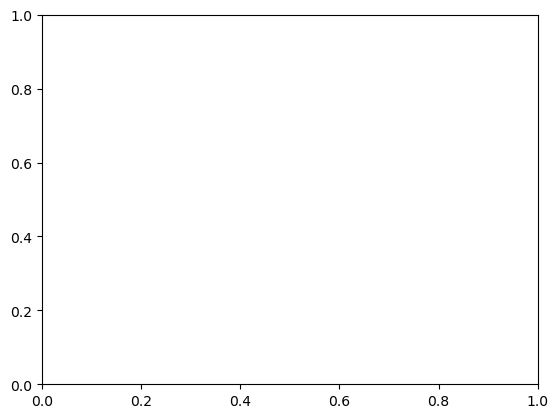

In [21]:
# checking the value count of rating, the vaue_count % and cummulative %
rating = pd.DataFrame({
    "count": df_final['rating'].value_counts(),
    "%": round(df_final['rating'].value_counts(normalize=True) * 100, 2)
    })
rating['cum %'] = rating["%"].cumsum() #cummulative percentage value count
print(rating)
print()

# plot the bar plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = sns.barplot(x=rating.index, y=rating['count'], palette="Spectral")

# show data labels of the bar plot
for i in ax1.containers:
    ax1.bar_label(i, )

 # add the line graph for cummulative value count percentage
ax2 = ax1.twinx()
ax2 = sns.lineplot(x=rating.index, y=rating['cum %'], size_order=rating.index)
ax2.grid(False)
ax2.set_ylabel("Cumm %", color='b')

# set title, x-axis label and y-axis label
ax1.set_xlabel('Rating Scale', color='b')
ax1.set_ylabel("Count", color='b')
plt.title("Rating Distribution", fontsize=12, color='b')

plt.show()

**Observations**
* More than 93% of the products have at least 3 rating, leaving only ~7% for products rated below 3. This indicates an overall good ratings for the products.
* Rating 5 has the highest rating of more than 50% of the dataset, followed by 4, 3, 2 and 1.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
columns = df_final.select_dtypes(np.object_).columns # Get the column names of user_id and prod_id

for col in columns:
  print(col)
  print(f'Unique Count: {df_final[col].nunique()}')
  print("-" * 20)

**Observations**
- There are potentially 8,761,060 possible ratings `(cartesian product of unique number of user_ids and prod_ids)`. However, there are just 65,290. This is understandable because not all users had purchased all the products. There are also cases where users do not provide ratings for purchased products.
-  On the average, users interacted with more than one product as the number of unique users, which is 1540,  exceed number of unique products 5689. This indicates an average of ~4 products per user.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings

# Create dataframe of users and value count
users = pd.DataFrame({
    "rating_count": df_final['user_id'].value_counts(),
    "%": round(df_final['user_id'].value_counts(normalize=True) * 100, 2)
    })
users.reset_index(inplace=True) #reset index
users.rename(columns={'index': 'user_id'}, inplace=True) #rename the index column to user_id
top_10_users = users.head(10) #Top 10 users based on number of ratings

print(top_10_users['rating_count'].sum(), round(top_10_users['%'].sum(), 2), sep=", ")
top_10_users

**Observations**
- The top 10 users based on number of rating account for `3.21%` of the total number of ratings.
- The user with the highest number of ratings had `295` ratings, while the 10th highest user had `179`.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean().values #Array of averages

# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count().values #Array of count

# Create a dataframe with calculated average and count of ratings
prod_ids = df_final.groupby('prod_id')['rating'].count().index #Array of prod_ids
final_rating = pd.DataFrame({
    'prod_id': prod_ids, 'avg_rating': avg_rating, 'rating_count': rating_count
})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction=100):
    """
    returns top n products based on minimum interations
    data: dataframe
    n: top number of products to return
    min_interactions: minimum number of rating counts a product should have
    """

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    #  Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.prod_id.iloc[:n]

In [ ]:
# Create function to print out top n products
def display_top_n_products(final_rating_, n, min_interaction=100):
  """
  prints out top n product to the console
  final_rating: final_rating dataframe
  n: top n
  min_interaction: minimum user-item interactions
  """

  print(f"Top {n} products with {min_interaction} minimum interations:")
  print("-" * 20)

  top_products = top_n_products(final_rating_, n, min_interaction).to_list()

  for i, prod in enumerate(top_products):
    print(f"{i + 1}. {prod}")
  print("-" * 20)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
display_top_n_products(final_rating, 5, 50)

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
display_top_n_products(final_rating, 5, 100)

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, testset, k=10, threshold=3.5):
    """
    Return precision and recall at k metrics for each user
    model: the model applied
    testset: test dataset
    k = maximum number of nearest neighbours
    threshold: minimum rating
    """

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    metrics = dict()
    metrics['Precision'] = precision  # Overall precion
    metrics['Recall'] = recall # Overall recall
    metrics['F_1 score'] = round((2*precision*recall)/(precision+recall), 3) #Overall F1 score

    print(metrics) #return dictionary of the metrics

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset

trainset, testset = train_test_split(data, test_size=0.3, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user, testset)

**Observations**
- We can observe that the baseline model has `RMSE=1.039` on the test set.
- Intuition of Recall - We are getting a **recall of ~0.785**, which means out of **all the relevant products, 78.5% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.852**, which means **out of all the recommended products, 85.2% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.82**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5

algo_knn_user.predict(user_id, prod_id, r_ui=r_ui, verbose=True)

- The actual rating for this user-product pair is 5 and predicted rating is 3.00 by this similarity based baseline model, which is a bit good.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
prod_id = "1400501466"

print(f"Unique user_ids where prod_id is not equal to {prod_id}:")
print("-" * 20)
print(df_final.loc[df_final['prod_id'] != prod_id]['user_id'].unique())
print("-" * 20)
print()

user_id = "A34BZM6S9L7QI4"
print(f"Is user_id '{user_id}' in the above list? {user_id in df_final.loc[df_final['prod_id'] != prod_id]['user_id'].unique()}")

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
prod_id = "1400501466"
user_id = "A34BZM6S9L7QI4"

algo_knn_user.predict(user_id, prod_id, verbose=True)

**Observations**
* The user-user similarity base model predicted a rating of ~4.29 for the user `A34BZM6S9L7QI4` and prod_id `1400501466`.
* The product has not been seen by the user and it appears to fall within the mean rating range.
* The model will be hyperparameter-tuned to make it better.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse'] # store in variable for re-use
print(best_params)

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
k = best_params['k'] # extracted from the best_param dict
min_k = best_params['min_k'] # extracted from the best_param dict
sim_options = best_params['sim_options'] # extracted from the best_param dict

# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_user_optimized = KNNBasic(k=k, min_k=min_k, sim_options=sim_options, verbose=False)

# Training the algorithm on the trainset
algo_knn_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
print("Based Model Metrics:")
precision_recall_at_k(algo_knn_user, testset=testset)
print("-" * 20)

print("Optimized Model Metrics:")
precision_recall_at_k(algo_knn_user_optimized, testset=testset)

**Observations**
- After tuning hyperparameters, RMSE for the test set has reduced from 1.04 to 0.98.
- It is clear that after tuning the hyperparameters, the tuned model's F-1 score increased from 0.817 to 0.825 in comparison to the baseline model. As a result, we can say that the model's performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5
algo_knn_user_optimized.predict(user_id, prod_id, r_ui, verbose=True)

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id, prod_id = "A34BZM6S9L7QI4", "1400501466"
algo_knn_user_optimized.predict(user_id, prod_id, verbose=True)

**Observations**
- The optimized user-user similarity model improved the rating on the test data and unseen data.
- It improved the user rating from 3 to 4.3 on the test data and from 4.29 to 4.30 on uninteracted product.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
algo_knn_user_optimized.get_neighbors(0, 5)

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating a user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
user_id, n = "A3LDPF5FMB782Z", 5 # user_id and top n products
recommendations = get_recommendations(df_final, user_id, n, algo_knn_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {
    "name": "cosine",
    'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item, testset=testset)

**Observations:**

- We can observe that the baseline model has `RMSE=1.03` and `F_1 Score=0.799`on the test set.
- We can try to improve the performance number by using `GridSearchCV` to tune different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5
algo_knn_user.predict(user_id, prod_id, r_ui, verbose=True)

**Observations**
- The item-item similarity base model produced an estimated rating of 3.80 against an actual of 5.00
- The base model will be hyperparameter tuned to explore possible improvements.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id, prod_id = "A34BZM6S9L7QI4", "1400501466"
algo_knn_item.predict(user_id, prod_id, verbose=True)

**Observations**
- The item-item similarity base model produced an estimated rating of 4.00 on a product the user has not interacted with.
- The base model will be hyperparameter-tuned to explore possible improvements.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine'],
                    'user_based': [False]}
  }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse'] # store in variable for re-use
print(best_params)

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
k = best_params['k'] # extracted from the best_param dict
min_k = best_params['min_k'] # extracted from the best_param dict
sim_options = best_params['sim_options'] # extracted from the best_param dict

# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_item_optimized = KNNBasic(k, min_k, sim_options, verbose=False, random_state=1)

# Training the algorithm on the trainset
algo_knn_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
print("Base model metrics:")
precision_recall_at_k(algo_knn_item, testset=testset)
print("-" * 20)

print("Optimized model metrics:")
precision_recall_at_k(algo_knn_item_optimized, testset=testset)

**Observations:**

- After tuning the hyperparameters, RMSE for the test set has reduced from 1.0345 to 0.9804.
- It can be observed that after tuning the hyperparameters, the tuned model's F-1 score increased from 0.799 to 0.816 in comparison to the baseline model. As a result, we can say that the model's performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5

algo_knn_item_optimized.predict(user_id, prod_id, r_ui, verbose=True)

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id, prod_id, r_ui = "A34BZM6S9L7QI4", "1400501466", None

algo_knn_item_optimized.predict(user_id, prod_id, r_ui, verbose=True)

**Observations**
- After hyperparameter tuning, the predictions improved the rating for users under the scenario of a user who had interacted with a product and a user who had not interacted with a product.
- For the first scenario, it improved from 3.8 to 4.53 and for the second, it improved from 4.00 to 4.30

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
algo_knn_item_optimized.get_neighbors(0, 5)

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_id, n = "A1A5KUIIIHFF4U", 5 # user_id and top n
recommendations = get_recommendations(df_final, user_id, n, algo_knn_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
algo_svd = SVD(random_state=1)

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE

# print out the metrics for the optimized similarity-based models
print("Metrics for Optimized user-user similarity model:")
precision_recall_at_k(algo_knn_user_optimized, testset)
print("-" * 20)
print()

print("Metrics for Optimized item-item similarity model:")
precision_recall_at_k(algo_knn_item_optimized, testset)
print("-" * 20)
print()
#------------------------------------------------------------

# display the metrics for the svd base model
print("Metrics for svd base model:")
precision_recall_at_k(algo_svd, testset=testset)

**Observations:**

- The **baseline F_1 score** of 0.827 for the matrix factorization model on the test set is higher in comparison to the optimized F_1 score for the user-user (0.825) and the baseline model.
- The result for the baseline SVD is better than both baseline and optimized item-item similarity-based recommendation systems.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5
algo_svd.predict(user_id, prod_id, r_ui, verbose=True)

**Observations**
- The svd base model offered a predicted rating of 4.26 against an actual rating of 5.
- This is very good. However, further improvement can be made through hyperparameter tuning of the base model.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
user_id, prod_id = "A34BZM6S9L7QI4", "1400501466"
algo_svd.predict(user_id, prod_id, verbose=True)

**Observations**
- The svd base model makes a predicted rating of 4.43 on product the user has not interacted with based on the latent attributes of the user-item.
- This is good. However, more improvement will be explored through hyperparameter tuning of the model.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
              'reg_all': [0.01, 0.02, 0.03, 0.04, 0.06, 0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
best_params = gs_svd.best_params['rmse']
print(best_params)

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
n_epochs = best_params['n_epochs'] # extracted from best param dict
lr_all = best_params['lr_all'] # extracted from best param dict
reg_all = best_params['reg_all'] # extracted from best param dict

algo_svd_optimized = SVD(n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, random_state=1)

# Train the algorithm on the trainset
algo_svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
print("svd base model metrics:")
precision_recall_at_k(algo_svd, testset)
print("-" * 20)
print()

print("optimized svd model metrics:")
precision_recall_at_k(algo_svd_optimized, testset)

**Observations**
- The svd base model could not be improved as the F_1 score produced lower value compared to the base model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id, prod_id, r_ui = "A3LDPF5FMB782Z", "1400501466", 5
algo_svd_optimized.predict(user_id, prod_id, r_ui, verbose=True)

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id, prod_id, r_ui = "A34BZM6S9L7QI4", "1400501466", None
algo_svd_optimized.predict(user_id, prod_id, r_ui, verbose=True)

## Checking Metrics for all the models

In [ ]:
# create function to display the metrics of an algorithm
def display_algo_metrics(algo, name_):
  print(f"Metrics for {name_}:")
  precision_recall_at_k(algo, testset)
  print("-" * 20)
  print()

In [ ]:
algos = {"Optimized sim_user-user": algo_knn_item_optimized,
         "Optimized sim_item-item": algo_knn_item_optimized,
         "Base svd model": algo_svd}

for key, item in algos.items():
  display_algo_metrics(item, key)

## **Conclusion and Recommendations**

- Recommendation systems were builts using four different algorithms. They are as follows:
  - Rank-based using averages-based popularity.
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering.

- Collaborative Filtering searches for neighbors based on similarity of products preferences and recommend products that those neighbors had purchased and rated while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- To demonstrate **"user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been used. For these algorithms, **grid search cross-validation is used to find the optimal hyperparameters for the data**, and improve the performance of the model**.

- **For performance evaluation** of these models, **precision@k and recall@k** are used. Using these two metrics, the F_1 score is calculated for each working model. F1_score was used as an evaluation basis as we set out the objective to maximize the number of recommended products that are relevent (`recall`) and the number of relevant products that are recommended (`precision`).

- Overall, the **matrix factorization** recommendation system** has given the **best performance** in terms of the F1-Score (~0.827).

- Matrix Factorization has the lowest RMSE (~0.91) due to the reason that it assumes that both products and users are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

- We can try to further improve the performance of these models using hyperparameter tuning.

- We can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.